In [3]:
import torch     # PyTorch
import datasets  # Huggingface Datasets; actual data

from IPython.display import display  # image display
import matplotlib.pyplot as plt      # image display
%matplotlib inline                   
import random
#Torchvision functions
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as functional
import torchvision.transforms as transforms

#training
from torch import nn as nn

#dataloader
from torch.utils.data import DataLoader

In [4]:
dataset = datasets.load_dataset("DrishtiSharma/Anime-Face-Dataset")

Found cached dataset parquet (/Users/boranollana/.cache/huggingface/datasets/DrishtiSharma___parquet/DrishtiSharma--Anime-Face-Dataset-1886e0ceeb6ab6bb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

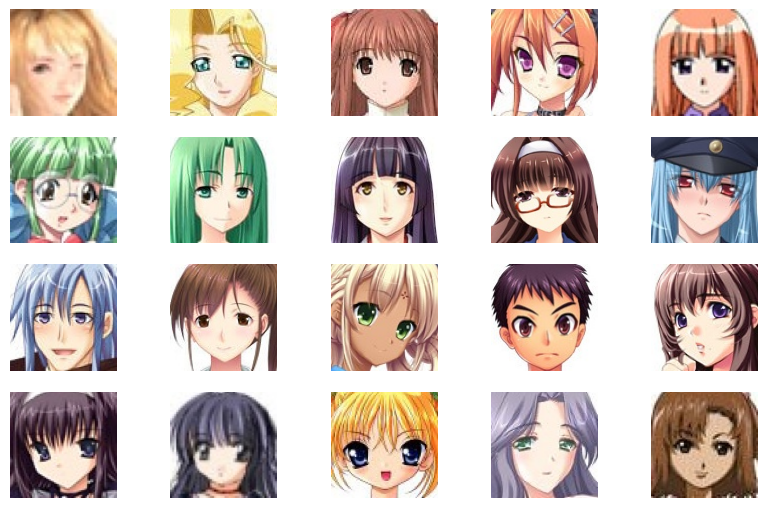

In [5]:
def display_sample( n ):
    
    images = []
    for i in range(0,n):
        images.append(  dataset['train'][ random.randint(0, 60000) ]['image']  )

    plt.figure(figsize=(10,8))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot( int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)
    
display_sample(20)

In [6]:
# Set the output size
output_size = (64, 64)

# Define a transform to resize the images
transform = transforms.Compose([
    transforms.Resize(output_size),
    transforms.ToTensor(),
])

# Create an empty list to store the resized images as tensors
resized_images = []

# Loop through each image in the dataset and resize it
for i in range( len(dataset['train']) ):
    image = dataset['train'][i]['image']  # Get the i-th image and its label
    image_resized = transform(image)  # Resize the image
    resized_images.append(image_resized)  # Add the resized image to the list
    
    if i % 1000 == 0:
        print("Making progress at ",i,"out of ",len(dataset['train']))

# Convert the list of tensors to a tensor stack
data = torch.stack(resized_images)

Making progress at  0 out of  63565
Making progress at  1000 out of  63565
Making progress at  2000 out of  63565
Making progress at  3000 out of  63565
Making progress at  4000 out of  63565
Making progress at  5000 out of  63565
Making progress at  6000 out of  63565
Making progress at  7000 out of  63565
Making progress at  8000 out of  63565
Making progress at  9000 out of  63565
Making progress at  10000 out of  63565
Making progress at  11000 out of  63565
Making progress at  12000 out of  63565
Making progress at  13000 out of  63565
Making progress at  14000 out of  63565
Making progress at  15000 out of  63565
Making progress at  16000 out of  63565
Making progress at  17000 out of  63565
Making progress at  18000 out of  63565
Making progress at  19000 out of  63565
Making progress at  20000 out of  63565
Making progress at  21000 out of  63565
Making progress at  22000 out of  63565
Making progress at  23000 out of  63565
Making progress at  24000 out of  63565
Making progre

In [7]:
print("Dataset tensor:", data.shape)
#creating dataloader from our tensor
images = DataLoader(data, batch_size=100, shuffle=False) #tune: batch size
#batch shape:
print("Batch shape:", next(iter(images)).shape)

Dataset tensor: torch.Size([63565, 3, 64, 64])
Batch shape: torch.Size([100, 3, 64, 64])


Discriminator class instance (not final)<br>
We could do hyperparameter search on the kernel size(better to keep kernel the same and change number of layers), stride and padding. <br><br>
With the below architecture, we won't have to manually input hidden layer sizes, just the number of layers.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nl, hs, ks, stride, pad):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(nn.Sequential(
                nn.Conv2d(3, hs, kernel_size=ks, stride=stride, padding=pad),
                nn.BatchNorm2d(hs),
                nn.ReLU()
            ))
        for i in range(1, nl-2):
            self.layers.append(nn.Sequential(
                #previous hidden layer size, next hidden layer size from array passed as argument to the constructor
                nn.Conv2d(hs*(2**(i-1)), hs*(2**i), kernel_size=ks, stride=stride, padding=pad), 
                nn.BatchNorm2d(hs*(2**i)),
                nn.ReLU()
            ))
        self.layers.append(nn.Sequential(
                nn.Conv2d(hs*(2**(nl-3)), 1,  kernel_size=ks, stride=stride, padding=pad),
                nn.Sigmoid()
            ))
    
    #forward pass, calls the class init
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self, nl, hs, ks, stride, pad):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Sequential(
                nn.ConvTranspose2d(64, hs*(2**(nl-3)), kernel_size=ks, stride=stride, padding=pad),
                nn.ReLU()
            ))
        for i in range(2, nl-1):
            self.layers.append(nn.Sequential(
                nn.ConvTranspose2d((int)((hs*(2**(nl-1)))/(2**i)), #in dimension
                                   (int)((hs*(2**(nl-1)))/(2*2**i)), #out dimension
                                   kernel_size=ks, stride=stride, padding=pad),
                nn.BatchNorm2d((int)((hs*(2**(nl-1)))/(2*2**i))), #out dimension
                nn.ReLU()
            ))
        #output layer
        self.layers.append(nn.Sequential(
                nn.ConvTranspose2d(hs, 3, kernel_size=ks, stride=stride, padding=pad),
                nn.Sigmoid()
            ))
        
    #forward pass, calls the class init
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
number_of_layers = 6
hidden_size = 64
kernel_size = 3
stride = 1
padding = 0
batch_size = 100
n_epochs = 1

In [11]:
gen = Generator(number_of_layers, hidden_size, kernel_size, stride, padding)
gen

Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)

In [12]:
dis = Discriminator(number_of_layers, hidden_size, kernel_size, stride, padding)
dis

Discriminator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)

In [13]:
#Binary cross entropy loss. Either fake or real image.
loss = nn.BCELoss()
optimizers = [torch.optim.AdamW(dis.parameters()), torch.optim.AdamW(gen.parameters())]
optimizers[0]

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [46]:
#batch shape:
next(iter(images)).shape

torch.Size([100, 3, 64, 64])

In [47]:
#We will use these to train the Discriminator: 
true_output = torch.full((100,1,54,54), 1.0) #Dont mess with the dimensions (Except batch size obv)
false_output = torch.full((100,1,54,54), 0.0) #Dont mess with the dimensions -...-

Training will tackle this minimax objective function:
$$minimax[\log(D(x)) + \log(1-D(G(z))]$$
Discriminator's job is to MAXIMIZE the function such that:<br> 
- $D(x)$ is close to 1. This is the prediction on the REAL images.<br>
- $D(G(z))$ is close to 0. This is the predictions on the FAKE images.<br>

Generator's job is to MINIMIZE the function such that:<br>
- $D(G(z))$ is close to 1. (Fooling the Discriminator into thinking the generated G(z) are real)

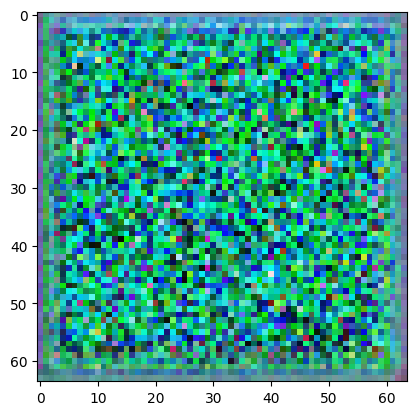

In [32]:
noise = torch.randn(100, 64, 54, 54) #initial random noise
import matplotlib.pyplot as plt
import numpy as np
generated = gen(noise)
generated[0].shape
gem = np.swapaxes(generated[0].detach().numpy(), 0, 2)
plt.imshow(gem)
plt.show()

In [55]:
#Training Loop here:
for epoch in range(n_epochs):
    for i, img in enumerate(images, 0):
        print("Batch #", i)
        #Discriminator Training:
        
        #Training for D(x) to approach 1:
        optimizers[0].zero_grad()                   #NOTE: use different optimizer 0-DISCRIMINATOR, 1-GENERATOR. *VERY IMPORTANT*
        output = dis(img)                           #forward pass on the discriminator
        dis_error_true = loss(output, true_output)  #Real images error.
        dis_error_true.backward()
        optimizers[0].step()                        #First Discriminator Update.
        
        #Training for D(G(z)) to approach 0:
        noise = torch.randn(100, 64, 54, 54)        #Rand noise  HAS to be 64,54,54. Had to finally figure this one out, the only way to get wanted output from generator. Probably an architecture problem here on the generator.
        generated = gen(noise)                      #BUGFIX: GENERATED Shape 3,64,64. DO NOT PLAY WITH NOISE DIMENSIONS
        output = dis(generated.detach())            #Detaching the generated from computation graph since we dont want it to update the discriminator.
        dis_error_false = loss(output, false_output)
        dis_error_false.backward()
        optimizers[0].step()                        #Second Discriminator Update.


        #Generator training:
        #Training for D(G(z)) to approach 1:
        optimizers[1].zero_grad()                   #check NOTE above.
        output = dis(generated)
        gen_error = loss(output, true_output)
        gen_error.backward()
        optimizers[1].step()
        
        print("True img error:", dis_error_true.item(), 
              "\nFalse img error:", dis_error_false.item(),
              "\nDiscriminator error mean:", (dis_error_true.item() + dis_error_false.item())/2,
              "\nGenerator error:", gen_error.item())
        if i == 3:
            break

        
        
        


torch.Size([100, 1, 54, 54])
True img error: 0.46404796838760376 
False img error: 0.7966488003730774 
Discriminator error mean: 0.6303483843803406 
Generator error: tensor(0.5521, grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([100, 1, 54, 54])
True img error: 0.17949172854423523 
False img error: 1.90874183177948 
Discriminator error mean: 1.0441167801618576 
Generator error: tensor(0.2323, grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([100, 1, 54, 54])
True img error: 0.08863687515258789 
False img error: 2.476501941680908 
Discriminator error mean: 1.282569408416748 
Generator error: tensor(0.1797, grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([100, 1, 54, 54])
True img error: 0.06701422482728958 
False img error: 2.4395501613616943 
Discriminator error mean: 1.253282193094492 
Generator error: tensor(0.1895, grad_fn=<BinaryCrossEntropyBackward0>)
